# Expected Calibration Error computation

In [1]:
!pip install pycocotools tqdm tidecv

In [7]:
import numpy as np
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import json
from tidecv import TIDE, datasets

from dataclasses import dataclass
from typing import List, Tuple, Dict, Set
from tqdm import tqdm
from collections import defaultdict

# Problem 1: Expected Calibration Error (ECE) 

ECE is a metric to evaluate the calibration of a model. It is defined as the expected value of the absolute difference between the accuracy and the confidence of the model. The confidence of the model is the probability assigned to the predicted class. The accuracy is 1 if the prediction is correct and 0 otherwise. The ECE is computed by dividing the confidence interval [0, 1] into M equally spaced bins and computing the weighted average of the absolute difference between the accuracy and the confidence in each bin. The weights are the proportion of samples in each bin. The ECE is defined as:

\begin{equation}
ECE = \sum_{m=1}^{M} \frac{B_m}{N} \left| \text{acc}(B_m) - \text{conf}(B_m) \right|
\end{equation}

where $B_m$ is the set of samples in bin $m$, $N$ is the total number of samples, $\text{acc}(B_m)$ is the accuracy of the model in bin $m$, and $\text{conf}(B_m)$ is the confidence of the model in bin $m$. The accuracy and confidence in bin $m$ are defined as:

\begin{equation}
\text{acc}(B_m) = \frac{1}{|B_m|} \sum_{i \in B_m} \mathbb{1} \left( y_i = \hat{y}_i \right)
\end{equation}

\begin{equation}
\text{conf}(B_m) = \frac{1}{|B_m|} \sum_{i \in B_m} p_i
\end{equation}

where $y_i$ is the true label of sample $i$, $\hat{y}_i$ is the predicted label of sample $i$, $p_i$ is the confidence of the model for sample $i$, and $\mathbb{1}(\cdot)$ is the indicator function.


## Starter Code

The following section contains some starter code to help you prepare the data using the COCO API. You can use this code to preprocess the data, or you can write your own code.

In [13]:
@dataclass
class Detection:
    bbox: np.ndarray  # [x1, y1, x2, y2]
    class_id: int
    confidence: float

@dataclass
class GroundTruth:
    bbox: np.ndarray  # [x1, y1, x2, y2]
    class_id: int

In [12]:
def coco_to_corners(bbox):
    """Convert COCO bbox [x,y,w,h] to corners format [x1,y1,x2,y2]"""
    return np.array([
        bbox[0],
        bbox[1],
        bbox[0] + bbox[2],
        bbox[1] + bbox[3]
    ])

def get_image_annotations(coco_gt, coco_dt, img_id, max_dets=100):
    """Get list of ground truth and detection annotations across all images"""
    gt_ids = coco_gt.getAnnIds(imgIds=img_id)
    gt_anns = coco_gt.loadAnns(gt_ids)
    gts = [
        GroundTruth(
            bbox=coco_to_corners(ann['bbox']),
            class_id=ann['category_id']
        )
        for ann in gt_anns
    ]

    # Get detections
    dt_ids = coco_dt.getAnnIds(imgIds=img_id)
    dt_anns = coco_dt.loadAnns(dt_ids)
    if max_dets is not None:
        dt_anns = sorted(dt_anns, key=lambda x: x['score'], reverse=True)[:max_dets]
    dets = [
        Detection(
            bbox=coco_to_corners(ann['bbox']),
            class_id=ann['category_id'],
            confidence=ann['score']
        )
        for ann in dt_anns
    ]

    return gts, dets

def prepare_inputs(coco_gt, coco_dt, max_dets=100):
    """Convert COCO format to TIDE format for all images"""
    all_gts = []
    all_dets = []
    
    for img_id in tqdm(coco_gt.getImgIds(), desc="Processing images"):
        gts, dets = get_image_annotations(coco_gt, coco_dt, img_id, max_dets)
        all_gts.extend(gts)
        all_dets.extend(dets)
    
    return all_gts, all_dets

In [ ]:
# # Download the Dataset by using Ultralytics API

# from ultralytics.data.utils import download
# download(url='https://github.com/ultralytics/yolov5/releases/download/v1.0/coco2017val.zip')

# with zipfile.ZipFile('coco2017val.zip', 'r') as zip_ref:
#     zip_ref.extractall()

In [ ]:
from ultralytics import YOLO
import json
import os

model = YOLO('yolov8n.pt')
results = model("datasets/coco/val2017", save=True)

# YOLO results to COCO format
coco_predictions = []
for result in results:
    for box in result.boxes:
        coco_predictions.append({
            "image_id": int(result.path.stem),
            "category_id": int(box.cls),
            "bbox": [float(box.xywh[0][0]), float(box.xywh[0][1]), float(box.xywh[0][2]), float(box.xywh[0][3])],
            "score": float(box.conf[0])
        })

json_file_path = "coco_predictions.json"
with open(json_file_path, "w") as f:
    json.dump(coco_predictions, f)

In [5]:
predictions_json = "coco_predictions.json"   # Path to the predictions JSON file
ground_truth_json = "datasets/coco/annotations/instances_val2017.json"  # Correct annotation file

coco_gt = COCO(ground_truth_json)       # Load ground truth annotations
coco_dt = coco_gt.loadRes(predictions_json) # Load predictions

loading annotations into memory...
Done (t=0.48s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.34s)
creating index...
index created!


In [6]:
gts, dets = prepare_inputs(coco_gt, coco_dt, max_dets=100)
len(gts), len(dets)

Processing images: 100%|██████████| 5000/5000 [00:00<00:00, 25908.33it/s]


(36781, 34596)

## Your task: implement code to compute the Expected Calibration Error.

## Solution

In [8]:
with open(predictions_json, "r") as f:
    predictions_data = json.load(f)

with open(ground_truth_json, "r") as f:
    ground_truth_data = json.load(f)

# Extract only annotations from ground truth (list of objects)
ground_truth_annotations = ground_truth_data["annotations"]

def ece_calculate(predictions, ground_truth, num_bins=10):
    bins = np.linspace(0, 1, num_bins + 1)

    # Extract confidence scores from predictions
    confidences = np.array([p["score"] for p in predictions])

    # Extract ground truth category IDs
    gt_category_ids = {gt["image_id"]: set() for gt in ground_truth}  # Group ground truth by image_id
    for gt in ground_truth:
        gt_category_ids[gt["image_id"]].add(gt["category_id"])

    # Compute correctness: If predicted category exists in the ground truth, mark as 1 - correct, else 0 - incorrect
    correct = np.array([1 if p["category_id"] in gt_category_ids.get(p["image_id"], []) else 0 for p in predictions])

    # Compute ECE
    bin_indices = np.digitize(confidences, bins) - 1
    bin_acc = [np.mean(correct[bin_indices == i]) if np.any(bin_indices == i) else 0 for i in range(num_bins)]
    bin_conf = [np.mean(confidences[bin_indices == i]) if np.any(bin_indices == i) else 0 for i in range(num_bins)]

    ece = np.sum(np.abs(np.array(bin_acc) - np.array(bin_conf)) * np.histogram(confidences, bins)[0] / len(confidences))
    return ece

# Compute ECE using the correct ground truth format
ece_value = ece_calculate(predictions_data, ground_truth_annotations)
print(f"ECE: {ece_value}")

ECE: 0.2308927360370347


# Problem 2: Compute TIDE statistics.

## Solution

-- coco_predictions --

bbox AP @ 50: 8.61

                         Main Errors
  Type      Cls      Loc     Both     Dupe      Bkg     Miss  
-------------------------------------------------------------
   dAP    48.84     0.56     0.03     0.02     0.15     2.19  

        Special Error
  Type   FalsePos   FalseNeg  
-----------------------------
   dAP       0.73       4.78  



c:\Users\vikra\anaconda3\Lib\site-packages\tidecv\plotting.py:139: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=error_dfs['main'], x='Delta mAP', y='Error Type', ax=ax,
c:\Users\vikra\anaconda3\Lib\site-packages\tidecv\plotting.py:156: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=error_dfs['special'], x='Error Type', y='Delta mAP', ax=ax,
c:\Users\vikra\anaconda3\Lib\site-packages\tidecv\plotting.py:161: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['FP', 'FN'])


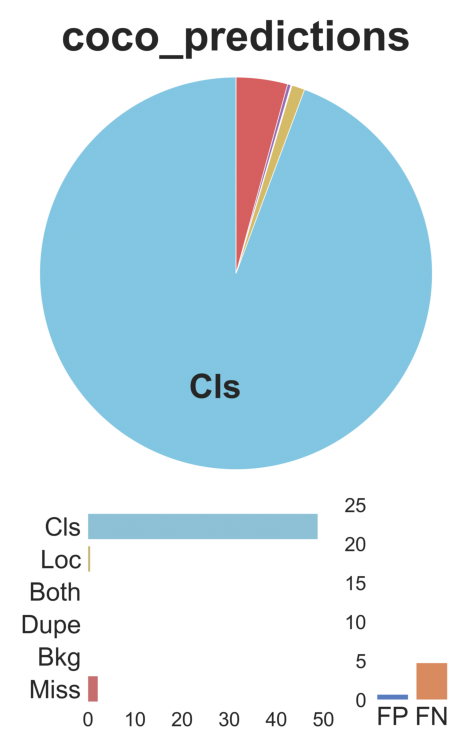

In [9]:
gt_dataset = datasets.COCO(ground_truth_json)
dt_dataset = datasets.COCOResult(predictions_json)

tide = TIDE()
tide.evaluate(gt_dataset, dt_dataset, mode=TIDE.BOX)
tide.summarize()
tide.plot()


# Problem 3: size-based analysis.

## Starter Code: Spatial Grid data structure.


## Spatial Grid Implementation

The `SpatialGrid` class implements a spatial indexing data structure that helps efficiently find nearby objects. Using this data structure is useful for our size-based analysis as it significantly reduces the time complexity of finding overlapping boxes.

### How it works:
1. The image space is divided into a grid of cells. The size of the cells is defined by the `cell_size` parameter.
2. Each bounding box is mapped to the cells it overlaps.
3. When searching for nearby objects, we only need to check objects in the relevant grid cells.

### Usage Example:
```python
grid = SpatialGrid(cell_size=100)
grid.add_box(0, [100, 100, 200, 200])  # Add a box with index 0, and bbox coordinates [100, 100, 200, 200]
nearby = grid.get_nearby_indices([150, 150, 250, 250])  # Find boxes near the bbox [150, 150, 250, 250]
```

In [5]:
class SpatialGrid:
    def __init__(self, cell_size: int = 100):
        """A spatial indexing structure for efficient nearby object queries.
        
        This data structure divides 2D space into a grid and maintains a mapping of
        which objects overlap with each grid cell, enabling efficient spatial queries.
        """
        self.cell_size: int = cell_size
        # self.grid = defaultdict(list)
        self.grid: Dict[Tuple[int, int], List[int]] = defaultdict(list)
    
    def get_cell_coords(self, bbox: np.ndarray) -> Set[Tuple[int, int]]:
        """Get all grid cells that a bounding box overlaps with.
        
        Args:
            bbox: Bounding box coordinates [x1, y1, x2, y2]
                where (x1, y1) is the top-left corner and (x2, y2) is the bottom-right corner

        Returns:
            Set of (x, y) grid cell coordinates
        """
        x1, y1, x2, y2 = bbox
        start_x = int(x1 // self.cell_size)
        end_x = int(x2 // self.cell_size)
        start_y = int(y1 // self.cell_size)
        end_y = int(y2 // self.cell_size)
        return {(i, j) for i in range(start_x, end_x + 1) 
                       for j in range(start_y, end_y + 1)}
    
    def add_box(self, idx: int, bbox: np.ndarray):
        """Add a bounding box to the spatial grid.
        
        Args:
            idx: Index of the bounding box
            bbox: Bounding box coordinates [x1, y1, x2, y2]
        """
        cells = self.get_cell_coords(bbox)
        for cell in cells:
            self.grid[cell].append(idx)
    
    def get_nearby_indices(self, bbox: np.ndarray) -> Set[int]:
        """Get indices of bounding boxes that are near the given bounding box.
        
        Args:
            bbox: Bounding box coordinates [x1, y1, x2, y2]
            
        Returns:
            Set of indices of nearby bounding boxes
        """
        cells = self.get_cell_coords(bbox)
        nearby = set()
        for cell in cells:
            nearby.update(self.grid[cell])
        return nearby

In [9]:
# Size thresholds as per COCO
SMALL_THRESH = 32 * 32
MEDIUM_THRESH = 96 * 96

## Your task: Implement the size-based ECE computation and Size-based TIDE computation:

## Solution:

loading annotations into memory...
Done (t=0.12s)
creating index...
index created!

Analyzing small objects...
Loading and preparing results...
DONE (t=0.04s)
creating index...
index created!


Processing images: 100%|██████████| 5000/5000 [00:00<00:00, 42112.75it/s]


ECE for small objects: 0.12887502587339783

Analyzing medium objects...
Loading and preparing results...
DONE (t=0.14s)
creating index...
index created!


Processing images: 100%|██████████| 5000/5000 [00:00<00:00, 48291.88it/s]


ECE for medium objects: 0.15358833936401287

Analyzing large objects...
Loading and preparing results...
DONE (t=0.05s)
creating index...
index created!


Processing images: 100%|██████████| 5000/5000 [00:00<00:00, 26996.56it/s]


ECE for large objects: 0.16464595028723078

Analyzing small objects...

TIDE Statistics for small objects:
-- coco_predictions_small --

bbox AP @ 50: 9.38

                         Main Errors
  Type      Cls      Loc     Both     Dupe      Bkg     Miss  
-------------------------------------------------------------
   dAP     0.46     1.29     0.08     0.02     0.85    60.12  

        Special Error
  Type   FalsePos   FalseNeg  
-----------------------------
   dAP       1.54      70.94  



c:\Users\Akshat\anaconda3\envs\cuda_env\Lib\site-packages\tidecv\plotting.py:139: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=error_dfs['main'], x='Delta mAP', y='Error Type', ax=ax,
c:\Users\Akshat\anaconda3\envs\cuda_env\Lib\site-packages\tidecv\plotting.py:156: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=error_dfs['special'], x='Error Type', y='Delta mAP', ax=ax,
c:\Users\Akshat\anaconda3\envs\cuda_env\Lib\site-packages\tidecv\plotting.py:161: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['FP', 'FN'])


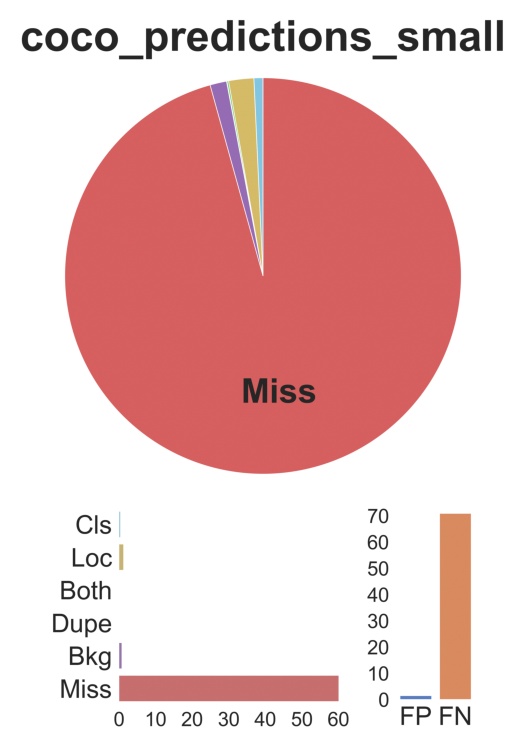


Analyzing medium objects...

TIDE Statistics for medium objects:
-- coco_predictions_medium --

bbox AP @ 50: 22.19

                         Main Errors
  Type      Cls      Loc     Both     Dupe      Bkg     Miss  
-------------------------------------------------------------
   dAP     0.64     2.34     0.24     0.02     0.94    58.00  

        Special Error
  Type   FalsePos   FalseNeg  
-----------------------------
   dAP       2.27      67.04  



c:\Users\Akshat\anaconda3\envs\cuda_env\Lib\site-packages\tidecv\plotting.py:139: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=error_dfs['main'], x='Delta mAP', y='Error Type', ax=ax,
c:\Users\Akshat\anaconda3\envs\cuda_env\Lib\site-packages\tidecv\plotting.py:156: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=error_dfs['special'], x='Error Type', y='Delta mAP', ax=ax,
c:\Users\Akshat\anaconda3\envs\cuda_env\Lib\site-packages\tidecv\plotting.py:161: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['FP', 'FN'])


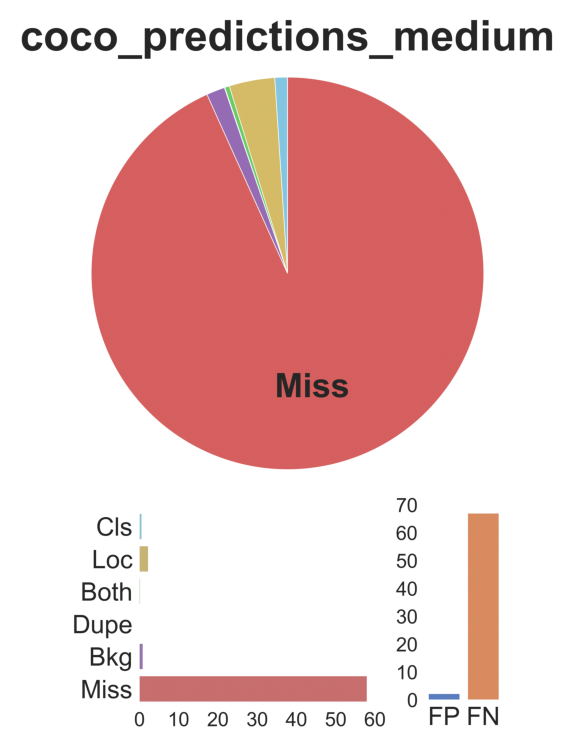


Analyzing large objects...

TIDE Statistics for large objects:
-- coco_predictions_large --

bbox AP @ 50: 31.29

                         Main Errors
  Type      Cls      Loc     Both     Dupe      Bkg     Miss  
-------------------------------------------------------------
   dAP     1.18     2.07     0.26     0.05     0.21    55.07  

        Special Error
  Type   FalsePos   FalseNeg  
-----------------------------
   dAP       1.56      62.91  



c:\Users\Akshat\anaconda3\envs\cuda_env\Lib\site-packages\tidecv\plotting.py:139: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=error_dfs['main'], x='Delta mAP', y='Error Type', ax=ax,
c:\Users\Akshat\anaconda3\envs\cuda_env\Lib\site-packages\tidecv\plotting.py:156: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=error_dfs['special'], x='Error Type', y='Delta mAP', ax=ax,
c:\Users\Akshat\anaconda3\envs\cuda_env\Lib\site-packages\tidecv\plotting.py:161: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['FP', 'FN'])


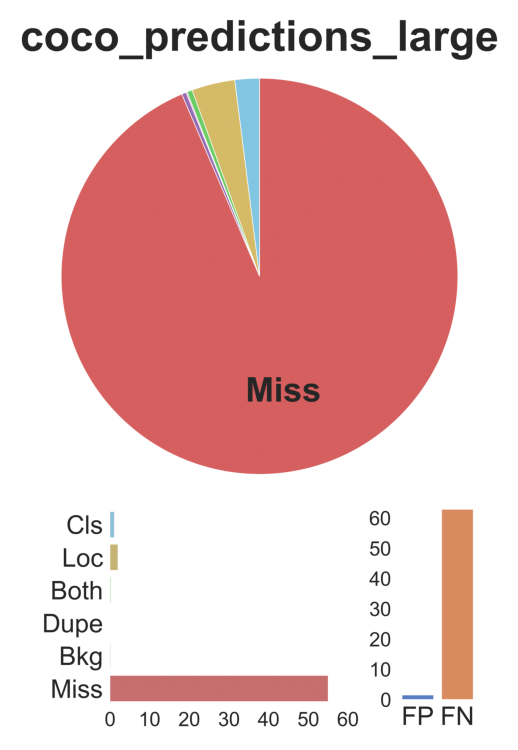

In [ ]:
with open(predictions_json, "r") as f:
    predictions_data = json.load(f)  # Now predictions_data is a list of dictionaries

with open(ground_truth_json, "r") as f:
    ground_truth_data = json.load(f)

# Extract ground truth annotations
ground_truth_annotations = ground_truth_data["annotations"]

# Filter predictions by object size
def size_filter(predictions, size_category):
    if size_category == "small":
        return [p for p in predictions if p.get('area', 0) < 36 * 36]
    elif size_category == "medium":
        return [p for p in predictions if 36 * 36 <= p.get('area', 0) < 96 * 96]
    else:  # large
        return [p for p in predictions if p.get('area', 0) >= 96 * 96]

# Compute ECE for each object scale
for category in ["small", "medium", "large"]:
    filtered_preds = size_filter(predictions_data, category)  # Use loaded JSON data
    ece_value = ece_calculate(filtered_preds, ground_truth_annotations)  # Pass parsed ground truth
    print(f"ECE for {category} objects: {ece_value}")
    
# Load Predictions JSON
with open(predictions_json, "r") as f:
    predictions_data = json.load(f)

# Compute TIDE statistics for each object scale
for category in ["small", "medium", "large"]:
    filtered_preds = size_filter(predictions_data, category)
    
    # Save filtered predictions to a separate file
    filtered_pred_file = f"coco_predictions_{category}.json"

    with open(filtered_pred_file, "w") as f:
        json.dump(filtered_preds, f)

    # Load filtered predictions using pycocotools
    coco_dt_filtered = coco_gt.loadRes(filtered_pred_file)

    # Convert to TIDE format
    gt_dataset = datasets.COCO(ground_truth_json)
    dt_dataset = datasets.COCOResult(filtered_pred_file)

    tide = TIDE()
    tide.evaluate(gt_dataset, dt_dataset, mode=TIDE.BOX)
    tide.summarize()
    tide.plot()